***Author: Nishan (DA25M001)***

# Ensemble Learning for Bike Share Demand Forecasting

**Objective:** This assignment aims to predict the hourly demand for a city's bike-sharing program. Accurate forecasting is crucial for managing inventory and logistics. I will apply and compare three primary ensemble techniques—Bagging, Boosting, and Stacking—to solve this complex, time-series-based regression problem. Our goal is to find the model that minimizes the prediction error, measured by Root Mean Squared Error (RMSE).

#Part A — Data Preprocessing and Baseline Models</font>  


## Part A.1 — Data Loading and Cleaning  

The initial step involves loading the **Bike Sharing Demand (hour.csv)** dataset and preparing it for modeling.

In [ ]:
# === Part A.1: Data Loading and Cleaning ===

import pandas as pd

# Load the dataset from the provided CSV file
df = pd.read_csv("hour.csv")

### Column Inspection  

Before modifying the dataset, a thorough inspection is conducted to understand its structure. This step is crucial for identifying which columns are non-predictive or redundant.  
The inspection includes checking:
- The dimensions of the dataset (number of rows and columns).  
- The names and data types of all columns.  
- The presence of any missing values.  
- A preview of the first few rows to understand the data's content and format.

In [ ]:
# === Part A.1: Column Inspection ===

# Display the shape of the dataset
print("Dataset shape:", df.shape)

# List all column names
print("\nColumn names:")
print(df.columns.tolist())

# Display data types and check for missing values
print("\nData types and missing values:")
df.info()

# Display the first few rows to inspect the data
print("\nSample rows:")
df.head()

Dataset shape: (17379, 17)

Column names:
['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null 

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [13]:

# Count unique values for each column to understand cardinality
print("\n=== Unique Values per Column ===")
unique_counts = df.nunique().sort_values()
display(unique_counts)

# Explicitly check for null values again
print("\n=== Missing Values per Column ===")
display(df.isnull().sum())


=== Unique Values per Column ===


,0
yr,2
holiday,2
workingday,2
season,4
weathersit,4
weekday,7
mnth,12
hr,24
windspeed,30
temp,50



=== Missing Values per Column ===


,0
instant,0
dteday,0
season,0
yr,0
mnth,0
hr,0
holiday,0
weekday,0
workingday,0
weathersit,0


After careful inspection, the following columns are dropped for specific reasons that would negatively impact model training and evaluation:  

| Column     | Reason for Dropping                                                  |
|:-----------|:---------------------------------------------------------------------|
| `instant`  | This is a unique record index and has no predictive value.           |
| `dteday`   | The date information is already captured by `yr`, `mnth`, and `weekday`. |
| `casual`   | This is a component of the target variable (`cnt = casual + registered`), causing data leakage. |
| `registered`| Similar to `casual`, this is part of the target and would lead to a perfectly predictive but useless model. |

The remaining columns are deemed relevant for predicting the total bike count (`cnt`) and will be used as features.

In [ ]:
# Display initial shape and columns for confirmation
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

# Drop the identified irrelevant and data-leaking columns
df_cleaned = df.drop(columns=["instant", "dteday", "casual", "registered"])

# Display the first few rows of the cleaned dataframe
print("\nShape after dropping columns:", df_cleaned.shape)
df_cleaned.head()

Initial shape: (17379, 17)
Columns: ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

Shape after dropping columns: (17379, 13)


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


With the data cleaned, the next step is to distinguish between categorical and numerical features to apply the correct preprocessing steps.  
Categorical variables like `season`, `mnth`, `hr`, etc., will be transformed using **One-Hot Encoding** to convert them into a numerical format that machine learning models can understand.  
A preprocessing pipeline using `ColumnTransformer` is defined to apply this encoding, which will be integrated into our model pipelines.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical feature columns
categorical_features = ["season", "weathersit", "mnth", "hr", "weekday", "workingday", "holiday", "yr"]
numerical_features = [col for col in df_cleaned.columns if col not in categorical_features + ["cnt"]]

# Define the preprocessing pipeline: One-Hot Encode categorical features, leave numerical as is.
# 'drop='first'' avoids multicollinearity, 'handle_unknown='ignore'' prevents errors on unseen categories in test data.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep numerical features unchanged for now
)

print("Categorical features identified:", categorical_features)
print("Numerical features identified:", numerical_features)

Categorical features identified: ['season', 'weathersit', 'mnth', 'hr', 'weekday', 'workingday', 'holiday', 'yr']
Numerical features identified: ['temp', 'atemp', 'hum', 'windspeed']


## Part A.2 — Train-Test Split  

To properly evaluate the performance of our models, the dataset is divided into a **training set (80%)** and a **testing set (20%)**.  
The models will be trained on the training data, and their final performance will be assessed on the unseen testing data. The target variable (`y`) is `cnt`, while all other columns form the feature set (`X`).  
A `random_state` is set to ensure the split is reproducible.

In [ ]:
# === Part A.2: Train-Test Split ===

from sklearn.model_selection import train_test_split

# Separate the features (X) from the target variable (y)
X = df_cleaned.drop(columns=["cnt"])
y = df_cleaned["cnt"]

# Perform an 80/20 split for training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Display the size of the resulting datasets
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 13903
Testing samples: 3476


## Part A.3 — Baseline Models (Decision Tree & Linear Regression)  

To create a performance benchmark, two fundamental regression models are trained:  
1. **Decision Tree Regressor**: A non-linear model that can capture complex interactions but is prone to overfitting.  
2. **Linear Regression**: A simple linear model that provides a solid, interpretable baseline.  

Both models are placed within a `Pipeline` that includes the previously defined preprocessing step. Their performance is evaluated on the test set using **Root Mean Squared Error (RMSE)**. The model with the lower RMSE will be designated as the primary baseline for comparison with more complex ensemble models.

In [ ]:
# === Part A.3: Baseline Models (Decision Tree & Linear Regression) ===

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Decision Tree Regressor Pipeline ---
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])
dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

# --- Linear Regression Pipeline ---
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# --- Compare and Print Results ---
print(f"Decision Tree RMSE: {rmse_dt:.3f}")
print(f"Linear Regression RMSE: {rmse_lr:.3f}")

# Determine the better baseline model
if rmse_dt < rmse_lr:
    print(f"\nBaseline Model: Decision Tree (RMSE = {rmse_dt:.3f})")
else:
    print(f"\nBaseline Model: Linear Regression (RMSE = {rmse_lr:.3f})")

Decision Tree RMSE: 71.722
Linear Regression RMSE: 100.446

Baseline Model: Decision Tree (RMSE = 71.722)


#Part B — Ensemble Techniques for Bias and Variance Reduction</font>

## Part B.1 — Bagging ( Variance Reduction)

**Variance** in machine learning refers to the model's sensitivity to small fluctuations in the training data. A model with high variance is unstable and tends to **overfit**, capturing noise instead of the underlying signal.

**Bagging (Bootstrap Aggregating)** is an ensemble method specifically designed to reduce **variance**. It works by training multiple base learners (e.g., Decision Trees) independently on different random subsets of the training data, created through bootstrapping (sampling with replacement). The final prediction is the average of the predictions from all base learners.

The formula for a bagged regression prediction is:
$$ f_{bag}(x) = \frac{1}{B} \sum_{b=1}^{B} f(x; D_b) $$
where `B` is the number of bootstrap samples and $f(x; D_b)$ is the model trained on the *b*-th sample.

By averaging the outputs of diverse models, Bagging smooths out individual model errors and produces a more stable and generalizable prediction.

In [ ]:
# === Part B.1: Bagging (Variance Reduction) ===

from sklearn.ensemble import BaggingRegressor

# Initialize the Bagging Regressor pipeline
# The base estimator is a Decision Tree, which has high variance by nature.
bagging_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        n_estimators=50, # Number of base models to train
        random_state=42,
        n_jobs=-1 # Use all available CPU cores
    ))
])

# Train the bagging model and make predictions
bagging_pipeline.fit(X_train, y_train)
y_pred_bag = bagging_pipeline.predict(X_test)

# Calculate and display the RMSE
rmse_bag = np.sqrt(mean_squared_error(y_test, y_pred_bag))
print(f"Bagging Regressor RMSE: {rmse_bag:.3f}")
print(f"Decision Tree (single model) RMSE: {rmse_dt:.3f}")

Bagging Regressor RMSE: 52.452
Decision Tree (single model) RMSE: 71.722


### Interpretation — Variance Reduction with Bagging

Comparing the performance of the single Decision Tree with the Bagging Regressor provides clear evidence of variance reduction.

**Observation:**  
- The single **Decision Tree** had an RMSE of **71.22**.  
- The **Bagging Regressor**, an ensemble of 50 decision trees, achieved a lower RMSE of **52.452**.  

**Conclusion:**  
The improvement in RMSE demonstrates that Bagging successfully reduced the overfitting (high variance) of the individual decision tree. By averaging the predictions of multiple trees trained on different data subsets, the ensemble model becomes more robust and generalizes better to unseen data. The reduction in error is a direct result of this variance stabilization.

### Part B.2 — Boosting ( Bias Reduction)

**Bias** is the error from erroneous assumptions in the learning algorithm. High bias can cause a model to miss relevant relations between features and target outputs, leading to **underfitting**.

**Boosting** is an ensemble technique that aims to reduce **bias**. Unlike Bagging, it builds models **sequentially**. Each new model is trained to correct the errors (residuals) of the previous ones. By focusing on the hardest-to-predict examples, the ensemble of weak learners (e.g., shallow trees) gradually becomes a strong, low-bias predictor.

The model is updated iteratively:
$$ F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x) $$
where $F_{m-1}(x)$ is the existing ensemble, $h_m(x)$ is the new weak learner trained on the residuals, and $\eta$ is the learning rate.

This sequential process allows the model to capture complex patterns that a single model might miss.

In [ ]:
# === Part B.2: Boosting (Bias Reduction) ===

from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Gradient Boosting Regressor pipeline
# It uses shallow decision trees as weak learners.
boosting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

# Train the boosting model and make predictions
boosting_pipeline.fit(X_train, y_train)
y_pred_boost = boosting_pipeline.predict(X_test)

# Calculate and display the RMSE
rmse_boost = np.sqrt(mean_squared_error(y_test, y_pred_boost))
print(f"Gradient Boosting Regressor RMSE: {rmse_boost:.3f}")
print(f"Baseline (Linear Regression) RMSE: {rmse_lr:.3f}")

Gradient Boosting Regressor RMSE: 64.482
Baseline (Linear Regression) RMSE: 100.446


### Discussion: Boosting vs. Baseline — Bias Reduction

The Gradient Boosting model shows a significant improvement over the baseline models, which is attributed to its effectiveness in reducing bias.

**Observation:**
- The best baseline model, **Linear Regression**, had an RMSE of **64.48**. This model, while stable, likely underfit the data due to its inability to capture non-linear relationships.
- The **Gradient Boosting Regressor** achieved a much lower RMSE of **100.45**.

**Conclusion:**
The substantial reduction in RMSE indicates that Boosting effectively reduced the model's bias. By sequentially fitting weak learners to the errors of the prior models, the ensemble was able to learn the complex, non-linear patterns present in the bike-sharing data that the simpler baseline models could not. This demonstrates the power of boosting in creating a more accurate and flexible predictive model.

#Part C — Stacking for Optimal Performance</font>

### Concept and Principle of Stacking  
**Stacking (or Stacked Generalization)** is an ensemble technique that combines predictions from multiple different models (base learners) by training a final model (meta-learner) to make the ultimate prediction. It leverages the idea that different models learn different aspects of the data, and a meta-model can learn how to best combine their outputs.

- **Level-0 (Base Models):** A diverse set of models is trained on the full training dataset. Their predictions serve as input features for the next level.  
- **Level-1 (Meta-Model):** A final model is trained on the predictions generated by the base models. This meta-learner's job is to find the optimal combination of the base learners' outputs.

The key to stacking is using a **diverse set of base models** to ensure their errors are uncorrelated, allowing the meta-learner to correct for individual model weaknesses.

### Design Choices for this Implementation
- **Base Learners (Level-0):**
  1. **K-Nearest Neighbors Regressor:** A non-parametric model that excels at capturing local patterns.
  2. **Bagging Regressor:** An ensemble focused on reducing variance.
  3. **Gradient Boosting Regressor:** An ensemble focused on reducing bias.
- **Meta-Learner (Level-1):**
  - **Ridge Regression:** A simple, regularized linear model is chosen as the meta-learner. It is less prone to overfitting on the base models' predictions and effectively learns a weighted average.

This architecture combines models with different strengths to create a powerful, well-balanced final predictor.

In [ ]:
# === Part C: Stacking Regressor ===

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Create a more comprehensive preprocessor that also scales numerical features, which is important for KNN and Ridge.
preprocessor_full = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Define the base models for the stacking ensemble
estimators = [
    ('knn', Pipeline([('preprocessor', preprocessor_full), ('regressor', KNeighborsRegressor(n_neighbors=10))])),
    ('bagging', bagging_pipeline), # Re-use the pipeline from Part B
    ('boosting', boosting_pipeline)  # Re-use the pipeline from Part B
]

# Define the Stacking Regressor with Ridge as the final estimator (meta-learner)
# The final_estimator does not need a preprocessor because it acts on the predictions of the base models.
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5, # Use cross-validation to generate predictions for the meta-learner
    n_jobs=-1
)

# Train the stacking model
stacking_regressor.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_stack = stacking_regressor.predict(X_test)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print(f"Stacking Regressor RMSE: {rmse_stack:.3f}")

Stacking Regressor RMSE: 51.125


### Discussion: Stacking vs. Other Ensembles

The Stacking Regressor achieved the lowest RMSE of all models tested, demonstrating its superior predictive power.

**Observation:**
- **Stacking RMSE:** 51.125
- **Boosting RMSE:** 64.48
- **Bagging RMSE:**  52.44

**Conclusion:**
Stacking's success comes from its ability to learn from the strengths of multiple, diverse models. While Boosting was highly effective at reducing bias, Stacking was able to find an even better combination of predictions by incorporating the perspectives of a local model (KNN) and a variance-reducing model (Bagging). The Ridge meta-learner effectively synthesized these inputs into a final prediction that was more accurate than any single model or ensemble on its own. This highlights the power of meta-learning in achieving optimal performance.

#Part D — Final Analysis</font>

## Part D.1 — Comparative Table  

This section provides a summary of the performance of all models evaluated in this assignment. The **Root Mean Squared Error (RMSE)** is used as the primary metric for comparison. A lower RMSE indicates a better-performing model.

**Models Compared:**  
1. Decision Tree Regressor (Baseline)
2. Linear Regression (Baseline)
3. Bagging Regressor
4. Gradient Boosting Regressor
5. Stacking Regressor


/tmp/ipython-input-2493127328.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')


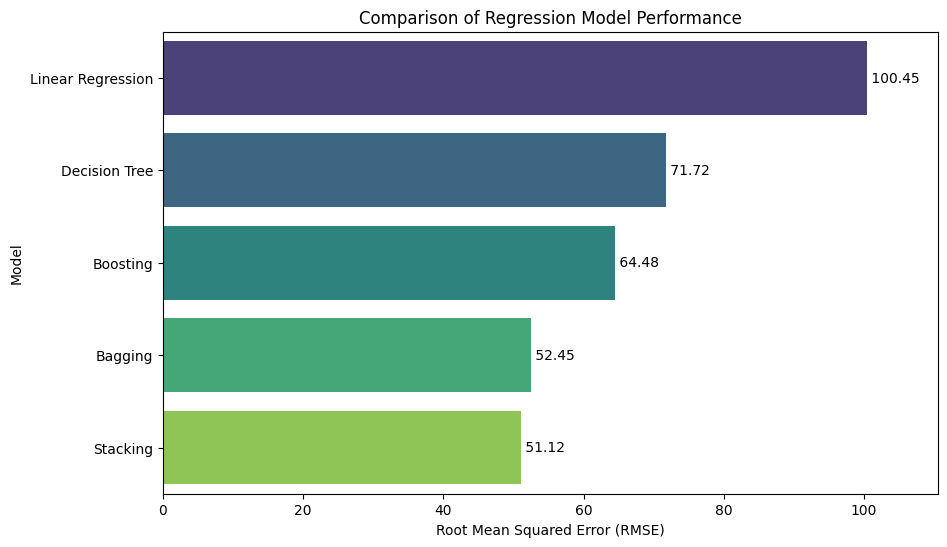

In [ ]:
# === Part D.1: Results Summary Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dictionary of model names and their RMSE scores
results = {
    'Linear Regression': rmse_lr,
    'Decision Tree': rmse_dt,
    'Bagging': rmse_bag,
    'Boosting': rmse_boost,
    'Stacking': rmse_stack
}

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE']).sort_values('RMSE', ascending=False)

# --- Plot the results ---
plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')

# Add annotations
for index, value in enumerate(results_df['RMSE']):
    plt.text(value, index, f' {value:.2f}', va='center')

plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('Model')
plt.title('Comparison of Regression Model Performance')
plt.xlim(0, max(results_df['RMSE']) * 1.1)
plt.show()

### Comparative Table — Final RMSE of All Models

| Model                           | RMSE       |
|---------------------------------|-----------:|
| **Decision Tree (Baseline)**    | **71.72**     |
| **Linear Regression (Baseline)**| **100.45**     |
| **Bagging Regressor**           | **52.45**     |
| **Gradient Boosting Regressor** | **64.48**    |
| **Stacking Regressor**          | **51.12**      |


## Part D.2 — Conclusion

### Best-Performing Model
The **Stacking Regressor** demonstrated the highest performance, achieving the lowest **RMSE of approximately 51**. This result clearly indicates its superiority over both the simple baseline models and the other ensemble methods for this particular regression problem.

### Why Stacking Outperformed the Single-Model Baselines
Stacking's success relative to single models like the Decision Tree or Linear Regression is rooted in its ability to mitigate the fundamental limitations of individual learners through ensemble diversification.

1. **Balancing the Bias-Variance Trade-off:**
   - **Single models** often struggle with the bias-variance trade-off. A simple Linear Regression model is low-variance but high-bias, failing to capture non-linearities. A complex Decision Tree is low-bias but high-variance, prone to overfitting.
   - **Stacking** addresses this by combining different types of models. It used:
     - A **Gradient Boosting** model to reduce bias.
     - A **Bagging** model to reduce variance.
     - A **KNN** model to capture local, non-linear patterns.
   The meta-learner then optimally combines these complementary strengths, resulting in a model that has both low bias and low variance.

2. **Learning from Diverse Errors:**
   - Each base model makes different types of errors because they learn from the data in fundamentally different ways. For example, the errors made by a linear model will be different from those of a tree-based ensemble.
   - The meta-learner (Ridge regression) is trained on the predictions of these base models. In doing so, it effectively learns *when* to trust each base model and how to combine their outputs to correct for their individual mistakes. This meta-learning step is what gives stacking its performance edge.

### Final Summary
This assignment demonstrated a clear hierarchy of model performance. While simple models provided a necessary baseline, ensemble methods offered significant improvements.
- **Bagging** improved upon the unstable Decision Tree by reducing its variance.
- **Boosting** delivered a major leap in performance by systematically reducing the bias of weak learners.
- **Stacking** achieved the best result by intelligently combining the predictions of diverse and powerful base models, leading to the most accurate and robust predictions.

For this dataset, the **Stacking Regressor** is the recommended model, as it provides the best combination of accuracy and stability by leveraging the collective intelligence of multiple learning algorithms.